In [1]:
from cleaning import clean_data, SMOTE_resample
import numpy as np
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from collections import Counter
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.ensemble import BaggingClassifier
import pandas as pd

(10495, 335)


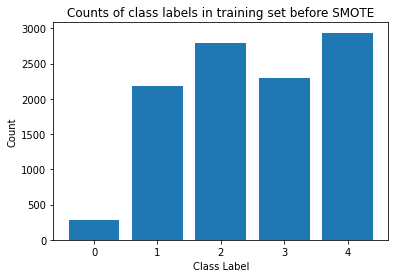

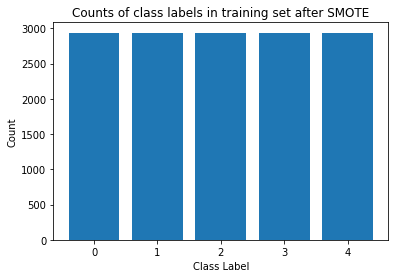

In [2]:
# Load Data
X_train, y_train, X_test, y_test = clean_data()
print(X_train.shape)

classes = [0, 1, 2, 3, 4]
c = Counter(y_train)
counts = [c[0], c[1], c[2], c[3], c[4]]

plt.bar(classes, counts)
plt.title(f'Counts of class labels in training set before SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

nsX_train = X_train
nsy_train = y_train
# SMOTE resampling
X_train, y_train = SMOTE_resample(X_train, y_train)

c = Counter(y_train)
counts = [c[0], c[1], c[2], c[3], c[4]]

plt.bar(classes, counts)
plt.title(f'Counts of class labels in training set after SMOTE')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [3]:
losses = ["hinge", "squared_hinge"]
learning_rates = [1e-3, 1e-2, 1e-1, 1, 10]
penalties = ["l1", "l2"]

random_grid = {
    "C": learning_rates,
    "penalty": penalties,
    "loss": losses,
}

kappa_scorer = make_scorer(cohen_kappa_score, weights='quadratic')
svc = LinearSVC(dual=False)
svc_random = RandomizedSearchCV(estimator=svc, param_distributions=random_grid, n_iter=10, cv=3, verbose=0, n_jobs=-1, error_score=np.NINF, scoring=kappa_scorer)
svc_random.fit(X_train, y_train)
print(f'Best Parameters = {svc_random.best_params_}')
print(f'Best Score = {svc_random.best_score_}')

c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-pack

Best Parameters = {'penalty': 'l2', 'loss': 'squared_hinge', 'C': 10}
Best Score = 0.3530903597415018


In [4]:
# Linear SVC
# best_params = {'penalty': 'l1', 'loss': 'squared_hinge', 'C': 10}
best_params = svc_random.best_params_
lsvc = LinearSVC(dual=False, penalty=best_params['penalty'], loss=best_params['loss'], C=best_params['C'])
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)
print(f'Train Score = {lsvc.score(X_train, y_train)}')
print(f'Test Score = {lsvc.score(X_test, y_test)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.3926505614154474
Test Score = 0.2881280569141841
Cohens Kappa Score = 0.23493118920473766


c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Noah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


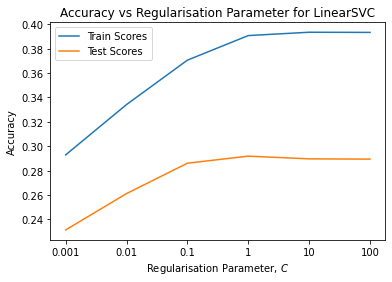

In [5]:
# Regularisation Parameter
regParam = [1e-3, 1e-2, 1e-1, 1, 10, 100]

trainScores = []
testScores = []
for C in regParam:
    lsvc = LinearSVC(dual=False, penalty='l1', loss='squared_hinge', C=C)
    lsvc.fit(X_train, y_train)
    trainScores.append(lsvc.score(X_train, y_train))
    testScores.append(lsvc.score(X_test, y_test))
regNames = [str(x) for x in regParam]

plt.plot(regNames, trainScores, label='Train Scores')
plt.plot(regNames, testScores, label='Test Scores')
plt.title(f'Accuracy vs Regularisation Parameter for LinearSVC')
plt.xlabel('Regularisation Parameter, $C$')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [8]:
# SVC
learning_rates = [1e-3, 1e-2, 1e-1, 1, 10, 100]
gammas = ['scale', 'auto']

param_grid = {
    "C": learning_rates,
    "gamma": gammas,
}

svc = SVC(kernel='rbf')
svc_grid = RandomizedSearchCV(estimator=svc, param_distributions=param_grid, cv=5, verbose=0, n_jobs=-1, error_score=np.NINF, scoring=kappa_scorer)
svc_grid.fit(X_train, y_train)
print(f'Best Parameters = {svc_grid.best_params_}')
print(f'Best Score = {svc_grid.best_score_}')

Best Parameters = {'gamma': 'scale', 'C': 100}
Best Score = 0.6506559373012826


In [10]:
# SVC
# best_params = {'C': 20, 'gamma': 'scale'}
best_params = svc_grid.best_params_
svc = SVC(kernel='rbf', gamma=best_params['gamma'], C=best_params['C'])
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(f'Train Score = {svc.score(X_train, y_train)}')
print(f'Test Score = {svc.score(X_test, y_test)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.9235794487921062
Test Score = 0.341929746554024
Cohens Kappa Score = 0.21450674081024879


In [11]:
# Bagging Classifier
bc = BaggingClassifier(base_estimator=svc, n_estimators=20, n_jobs=-1)
bc.fit(X_train, y_train)
y_pred = bc.predict(X_test)
print(f'Train Score = {bc.score(X_train, y_train)}')
print(f'Test Score = {bc.score(X_test, y_test)}')
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f'Cohens Kappa Score = {kappa}')

Train Score = 0.9265736645117387
Test Score = 0.3454868830591374
Cohens Kappa Score = 0.22745134726448712


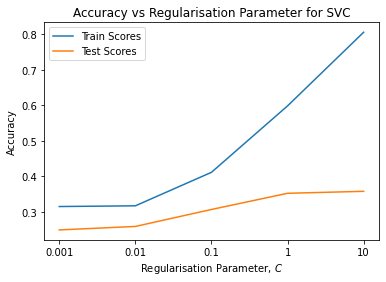

In [12]:
# Regularisation Parameter
regParam = [1e-3, 1e-2, 1e-1, 1, 10]

trainScores = []
testScores = []
for C in regParam:
    svc = SVC(kernel='rbf', gamma='scale', C=C)
    svc.fit(X_train, y_train)
    trainScores.append(svc.score(X_train, y_train))
    testScores.append(svc.score(X_test, y_test))
regNames = [str(x) for x in regParam]

plt.plot(regNames, trainScores, label='Train Scores')
plt.plot(regNames, testScores, label='Test Scores')
plt.title(f'Accuracy vs Regularisation Parameter for SVC')
plt.xlabel('Regularisation Parameter, $C$')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [11]:
# SMOTE results
svc = SVC(kernel='rbf', gamma='scale')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
kappa = cohen_kappa_score(y_test, y_pred, weights='quadratic')

nssvc = SVC(kernel='rbf', gamma='scale')
nssvc.fit(nsX_train, nsy_train)
nsy_pred = nssvc.predict(X_test)
nskappa = cohen_kappa_score(y_test, nsy_pred, weights='quadratic')

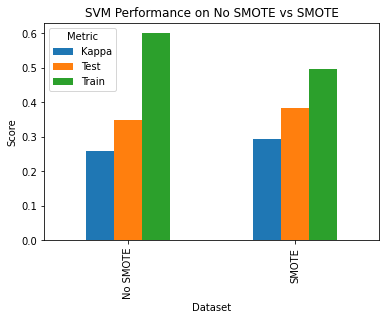

In [12]:
df = pd.DataFrame([['Kappa', 'No SMOTE', kappa], ['Kappa', 'SMOTE', nskappa],
                   ['Test', 'No SMOTE', svc.score(X_test, y_test)], ['Test', 'SMOTE', nssvc.score(X_test, y_test)],
                   ['Train', 'No SMOTE', svc.score(X_train, y_train)], ['Train', 'SMOTE', nssvc.score(nsX_train, nsy_train)]],
                   columns=['Metric','Dataset','val'])
df.pivot("Dataset", "Metric", "val").plot(kind='bar')
plt.ylabel('Score')
plt.title('SVM Performance on No SMOTE vs SMOTE')
plt.show()